# Build an interface between deepXDE and Altair Simulation

In [1]:
# NOTE: PyNastran to read an optistruct OP2 file, you may have to add the 
# correct OptiStruct version as follows:
# file:    "C:\Users\ewhalen\Miniconda3\envs\pinnDSE\Lib\site-packages\pyNastran\op2\op2_interface\op2_reader.py"
# change:  elif version in [b'OS11XXXX', b'OS12.210', b'OS14.210',
#                      b'OS2017.1', b'OS2017.2', b'OS2018.1', b'OS2020']:

import numpy as np
import pandas as pd
from pyNastran.op2.op2 import read_op2
from pyNastran.op2.op2_geom import read_op2_geom
import pyvista as pv
import trimesh

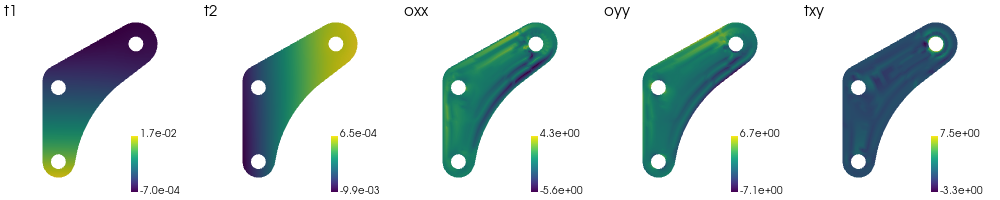

In [2]:
# assumes nodes ids are contiguous and start at 1
def loadOptistructResults(op2File, loadNodalStress=False, colNames=['t1', 't2']):
    res = read_op2(op2File, build_dataframe=True, debug=False, mode='optistruct');
    resDf = res.displacements[1].data_frame
    resDf = resDf.set_index('NodeID')
    
    if loadNodalStress:
        colNames += ['oxx', 'oyy', 'txy', 'von_mises']
        stressDf = res.cquad4_stress[1].data_frame
        nodeStressDf = stressDf.groupby('NodeID').mean().drop('CEN')
        resDf = resDf.join(nodeStressDf)

    resDf = resDf[colNames]
    return resDf

# assumes nodes ids are contiguous and start at 1
def loadOptistructModel(op2File):
    geom = read_op2_geom(op2File, build_dataframe=True, debug=False)
    nodeDict = geom.nodes
    elemDict = geom.elements
    vertices = np.array([n.get_position() for nid, n in nodeDict.items()])
    faces = np.array([[len(e.nodes)] + [nid-1 for nid in e.nodes] for eid, e in elemDict.items()]).flatten()
    mesh = pv.PolyData(vertices, faces, n_faces=len(elemDict))
    return mesh

def plotScalarFields(mesh, resDf, fieldList=['t1', 't2', 'oxx', 'oyy', 'txy'], cpos='xy'):
    plotter = pv.Plotter(shape=(1,len(fieldList)), border=False)
    for i,field in enumerate(fieldList):
        plotter.subplot(0,i)
        plotter.set_background('white')
        plotter.add_text(field, color='k', font_size=7)
        plotter.add_mesh(mesh.copy(), show_edges=False, scalars=resDf[field])
        plotter.add_scalar_bar(n_labels=2, label_font_size=10, width=0.1, height=0.3, 
                               vertical=True, position_x=0.65, fmt="%.1e", color='k')
    
    plotter.show(window_size=(200*len(fieldList),200), cpos=cpos);
    
    
def pyvistaToTrimesh(mesh):
    pvTriMesh = pv.PolyDataFilters.triangulate(mesh)
    faces = pvTriMesh.faces.reshape(-1,4)[:,1:]
    points = pvTriMesh.points
    return trimesh.Trimesh(points, faces, process=False)

def getAllBoundaries(mesh):
    bndEdges = mesh.extract_feature_edges(boundary_edges=True, non_manifold_edges=False, feature_edges=False, manifold_edges=False)
    bndEdgesCon = bndEdges.connectivity()
    bndIds = np.unique(bndEdgesCon['RegionId'])
    bndDict = {}
    for bndId in bndIds:
        cellIds = np.where(bndEdgesCon.cell_arrays['RegionId']==bndId)
        bndDict[bndId] = bndEdgesCon.extract_cells(cellIds)
    
    return bndDict

def sampleDomain(mesh, N, seed=1234):
    tmesh = pyvistaToTrimesh(mesh)
    np.random.seed(seed)
    samples, face_index = trimesh.sample.sample_surface_even(tmesh, N)
    return samples

def sampleBoundary(bnd, N, seed=1234):
    np.random.seed(seed)
    samples = np.zeros((N,3))
    for n in range(N):
        eid = np.random.choice(range(bnd.n_cells))
        edge = bnd.extract_cells(eid)
        vi,vj = edge.points
        w = np.random.rand()
        samples[n,:] = w*vi+(1-w)*vj
    return samples
    

op2File = 'data/controlArm/v1.0/controlArm01_nom.op2'
resDf = loadOptistructResults(op2File, loadNodalStress=True)
mesh = loadOptistructModel(op2File)

plotScalarFields(mesh, resDf)

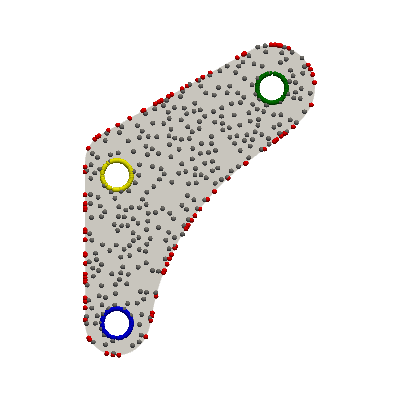

In [15]:
plotter = pv.Plotter(border=False)
plotter.set_background('white')
plotter.add_mesh(mesh, show_edges=False)

# sample domain
samples = sampleDomain(mesh, 300)
pc = pv.PolyData(samples)
plotter.add_mesh(pc, render_points_as_spheres=True, color='gray')

# sample boundary
bndDict = getAllBoundaries(mesh)
for bndId, color in zip(bndDict.keys(), ['red', 'green', 'blue', 'yellow']):
    samples = sampleBoundary(bndDict[bndId], 100)
    pc = pv.PolyData(samples)
    plotter.add_mesh(pc, render_points_as_spheres=True, color=color)

plotter.show(window_size=(400,400), cpos='xy');